In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import scipy
from scipy.stats import zscore, probplot
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.cluster import DBSCAN

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
#pd.options.display.max_seq_items = 8000
#pd.options.display.max_rows = 8000

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Load the datasets

train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [ ]:
print(f'The trainning set has {train.shape[0]} rows and {train.shape[1]} columns')
print(f'The test set has {test.shape[0]} rows and {test.shape[1]} columns')

In [ ]:
train.head()

In [ ]:
test.head()

## Feature engeneering 

Concatenate the two datasets 

In [ ]:
train_id = train['Id']

In [ ]:
#train_id = train['Id']
data = pd.concat((train, test)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)
print(f"data size is : {data.shape}")

In [ ]:
# Percentage of null values 

null = (data.isnull().sum() / len(data)) * 100
null = null.drop(null[null == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :null})
missing_data.head(20)

In [ ]:
# Plot the percentage of null values 

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=null.index, y=null)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [ ]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 

data['OverallCond'] = data['OverallCond'].astype(str)
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

#### Dealing with missing values 

According to the documentation:

* **PoolQC** : data description says NA means "No Pool".
* **MiscFeature** : data description says NA means "no misc feature".
* **Alley** : data description says NA means "no alley access".
* **Fence** : data description says NA means "no fence".
* **FireplaceQu** : data description says NA means "no fireplace".
* **LotFrontage** : We will fill in missing values by the median LotFrontage of the neighborhood.
* **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None
* **GarageYrBlt**, **GarageArea** and **GarageCars** : Replacing missing data with 0 since No garage = no cars in the garage.
* **BsmtFinSF1**, **BsmtFinSF2**, **BsmtUnfSF**, **TotalBsmtSF**, **BsmtFullBath** and **BsmtHalfBath** : missing values are likely zero for having no basement
* **BsmtQual**, **BsmtCond**, **BsmtExposure**, **BsmtFinType1** and **BsmtFinType2** : For these categorical features, NaN means that there is no basement.
* **MasVnrArea** and **MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
* **MSZoning** (The general zoning classification) : Fill in missing values with the the value that occurs the most
* **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
* **Functional** : data description says NA means typical.
* **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
* **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
* **Exterior1st** and **Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string.
* **SaleType** : Fill in again with most frequent value.
* **MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [ ]:
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"):
    data[col] = data[col].fillna("None")
    
# Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Replacing missing values with none 
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

# No garage no car
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)
    
# No basement = 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)
    
# For these categorical features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
    
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

# Filling in the Na values with the value that occues the most
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

# Drop the column 'Utilities'
data = data.drop(['Utilities'], axis=1)

# Typical as 'Typ'
data["Functional"] = data["Functional"].fillna("Typ")

# Only one missing value
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

# 'WD' is the most comom value
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

data['MSSubClass'] = data['MSSubClass'].fillna("None")

In [ ]:
# Look for any missing value 

null = (data.isnull().sum() / len(data)) * 100
null = null.drop(null[null == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :null})
missing_data.head(20)

That are no missing in the dataset 

### Fixing Skewness

Now we are going to fix skewness for the rest of the dataset. First we will focus on the "SalePrice" variable using the **train** dataset

In [ ]:
train.SalePrice.describe()

The Minimum value is not zero, which is a good thing 

In [ ]:
# Find out the skewness and kurtosis

print(f"Skewness: {train['SalePrice'].skew()}")
print(f"Kurtosis: {train['SalePrice'].kurt()}")

**Skewness** is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution.
It differentiates extreme values in one versus the other tail. A symmetrical distribution will have a skewness of 0. There are two types of Skewness: Positive and Negative


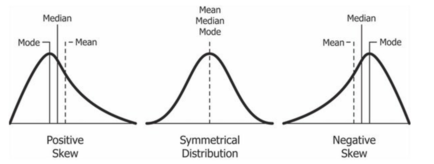


**Kurtosis** is all about the tails of the distribution — not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. It is actually the measure of outliers present in the distribution.

In [ ]:
# Histogrm, Q-Q plot 

sns.set(rc={'figure.figsize':(9,6)}) # set the size of the seabron graphs
sns.histplot(data = train.SalePrice)

fig = plt.figure()
res = scipy.stats.probplot(train['SalePrice'], plot=plt)
plt.show()

fig = plt.figure()
sns.residplot(data=train, x='GrLivArea', y='SalePrice');
plt.show()

Through the histogram and Q-Q plot plotted above we can see that the output variable is positively skewed (the mean and median are greater than the mode) meaning that a great deal of houses are being sold for less than the mean.

The Residual plot shows that the target variable has an unequal level of variance across most independent variables. This is called Heteroscedasticity (it will be explained soon) and is a red flag for the multiple linear regression model.

In [ ]:
# Make the output variable normally distributed

train['SalePrice'] = np.log1p(train['SalePrice']) # Using the log tranform we get a normally distributed output

sns.histplot(data = train.SalePrice)

fig = plt.figure()
res = scipy.stats.probplot(train['SalePrice'], plot=plt)
plt.show()

fig = plt.figure()
sns.residplot(data=train, x='GrLivArea', y='SalePrice');
plt.show()

Now our variable looks more like a normal distribution, that variance also looks more distributed, however The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. Maybe they refer to agricultural area and that could explain the low price. These two points are not representative of the typical case. Therefore, we'll define them as outliers and shuld delete them but since we are not considering the outliers of other variables, we are going to leave it as it is. 

In [ ]:
#train.sort_values(by = 'GrLivArea', ascending = False)[:2]

In [ ]:
#train = train.drop(train[train['Id'] == 1299].index)
#train = train.drop(train[train['Id'] == 524].index)

#sns.residplot(data=train, x='GrLivArea', y='SalePrice', color='r');

## Create the y_train variable

In [ ]:
y_train = train['SalePrice']

## What is necessary in Regression 

* **Linearity.**
* **Homoscedasticity vs Heteroscedasticity ).**
* **Independence of Errors.**
* **Multivariate Normality.**
* **No or little Multicollinearity.**


When fitting a linear model, "*we assume that the relationship is **linear**, and the errors, or residuals, are pure random fluctuations around the true line. We expect that the variability in the response(dependent) variable doesn't increase as the value of the predictor(independent) increases, which is the assumptions of equal variance, also known as **Homoscedasticity**. We also assume that the observations are independent of one another(No **Multicollinearity**), and a correlation between sequential observations or auto-correlation is not there. More information [here](http://www.kaggle.com/code/masumrumi/a-detailed-regression-guide-with-house-pricing).
                                                                                 
The problems usually appear all together, if we see one of these assumptions in the dataset, it's likely that we may come across with others aforementioned. So we will have to fix it. **Let´s get to work**.
                                                                                        

### Linearity

A linear regression needs the relationship between each independent variable and the dependent variable to be linear. We can see this through scatter plots. Linearity can be seen with scatter plots, where no or little linearity is present.

In [ ]:
## Plot sizing. 
fig, (ax1, ax2) = plt.subplots(figsize = (12,8), ncols=2,sharey=False)

## Putting a regression line. 
sns.regplot(x=train.GrLivArea, y=train.SalePrice, ax=ax1)

## regression line for MasVnrArea and SalePrice. 
sns.regplot(x=train.LotArea, y=train.SalePrice, ax=ax2);

We are plotting our target variable with two independent variables **GrLivArea** and **LotArea**. We can see from the chart that there is a better linear relationship between **SalePrice** and **GrLivArea** than **SalePrice** and **LotArea**. It's possible to see there are some outliers in the dataset. We have to check for outliers since linear regression is sensitive to outlier effects. Sometimes we are trying to fit a linear regression model when the data is not linear, or the function may need another degree of freedom to fit the data. In that case, we may need to change our function depending on the data to get the best possible fit. In addition to that, we can also check the residual plot, which tells us how is the error variance across the true line.

The residual plot for the variable "GrLivArea" was already plotted. We can notice that when applying the **log1p** transform on the "SalePrice" varible, the graph lost it's conical shape and presents the concept of **Homoscedasticity** (almost an equal amount of variance across the zero lines), the opposite is **Hemoscedasticity**.

**Multivariate Normality**: The linear regression analysis requires the dependent variable to be multivariate normally distributed. A histogram, box plot, or a Q-Q-Plot can check if the target variable is normally distributed. The goodness of fit test, e.g., the Kolmogorov-Smirnov test can check for normality in the dependent variable. We already know that our target variable did not follow a normal distribution. Let's bring back the three charts to show our target variable.

**No or Little multicollinearity:** Multicollinearity occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent. If the degree of correlation between variables is high enough, it can cause problems when you fit the model and interpret the results.

* The coefficient estimates can swing wildly based on which other independent variables are in the model. The coefficients become very sensitive to small changes in the model.
* Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of your regression model. You might not be able to trust the p-values to identify independent variables that are statistically significant.

We can check for multicollinearity using a heatmap (excelent tool).

In [ ]:
plt.subplots(figsize = (30,25))
sns.heatmap(data.corr(), annot=True)

* There is 0.83 or 83% correlation between GarageYrBlt and YearBuilt.
* 83% correlation between TotRmsAbvGrd and GrLivArea.
* 89% correlation between GarageCars and GarageArea.
* Similarly many other features such asBsmtUnfSF, FullBath have good correlation with other independent feature.

### Fixing Skewness

In [ ]:
# Remove the Id variable from the "data" dataset, for they are unique for each row and hence not useful for the model

data.drop(['Id'], axis=1, inplace=True)
data.shape

In [ ]:
# Find out the most skewed features 

num_features = data.dtypes[data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_features = data[num_features].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.head(10)

Plot the didtribution of the numerical vars 

In [ ]:
f, ax = plt.subplots(7, 6, figsize=(25, 30))
num_vars = data.columns[data.dtypes != 'object']
for i, c in enumerate(num_vars):
    g = sns.histplot(data[c], ax=ax[i//6, i%6], color='r')
    g.spines[['top', 'right']].set_visible(False)
f.text(0.4, .90, 'Distribution of numerical vars', size=20, weight='bold', color='black')
plt.show()

### Box cox transformation

A Box cox transformation is defined as a way to transform non-normal dependent variables in our data to a normal shape through which we can run a lot more tests than we could have

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)

In [ ]:
f, ax = plt.subplots(7, 6, figsize=(25, 30))
num_vars = data.columns[data.dtypes != 'object']
for i, c in enumerate(num_vars):
    g = sns.histplot(data[c], ax=ax[i//6, i%6], color='r')
    g.spines[['top', 'right']].set_visible(False)
f.text(0.4, .90, 'Distribution of numerical vars', size=20, weight='bold', color='black')
plt.show()

### Create interesting features

ML models have trouble recognizing more complex patterns, so we are going to help our models out by creating new features based on the dataset.

In [ ]:
data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'])
data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])
data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### Deleting a few features useless features

In [ ]:
data = data.drop(['Street', 'PoolQC',], axis=1)

## Treating outliers


We are going to remove outliers using the quantiles of each numerical columns. 

In [ ]:
num_feat = data.dtypes[data.dtypes != "object"].index

In [ ]:
for col in data[num_feat].columns:
    percentiles = data[col].quantile([0.01, 0.99]).values
    data[col] = np.clip(data[col], percentiles[0], percentiles[1])

### Encoding 

When we create a Machine learning algorithm, the model require all input and output variables to be numeric, meaning that if the data contains categorical data we have to encode it to numbers before fitting and evaluating our model. The two most popular techniques are **Ordinal Encoding** and **One-Hot Encoding**.

**Numerical data**, involves features that are composed of numbers, such as integers or floating-point values. **Categorical data**, on the other hand, are variables that contain label values rather than numeric. Categorical variables are often called nominal, some examples include:

* An “animal” variable with the values: “fish” and “turtle“.
* A “color” variable with the values: “black“, “white“, and “gray“.

A numerical variable can be converted to an ordinal variable by dividing the range of the numerical variable into bins and assigning values to each bin. For example, a numerical variable between 1 and 10 can be divided into an ordinal variable with 5 labels with an ordinal relationship: 1-2, 3-4, 5-6, 7-8, 9-10. This is called discretization.

* Nominal Variable (Categorical). Variable comprises a finite set of discrete values with no relationship between values.
* Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. In general, this is mostly a constraint of the efficient implementation of machine learning algorithms rather than hard limitations on the algorithms themselves. Some implementations of machine learning algorithms require all data to be numerical. For example, scikit-learn has this requirement. 

There are three common approaches for converting ordinal and categorical variables to numerical values. They are:

* Ordinal Encoding
* One-Hot Encoding
* Dummy Variable Encoding

In **ordinal encoding**, each unique category value is assigned an integer value. For example, “red” is 1, “green” is 2, and “blue” is 3, this is called an ordinal encoding or an integer encoding and is easily reversible. Often, integer values starting at zero are used. For some variables, an ordinal encoding may be enough. The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship.

**One-hot encoding** is used in categorical variables where no ordinal relationship exists, the integer encoding may not be enough, at best, or misleading to the model at worst. Forcing an ordinal relationship via an ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories). In this case, a one-hot encoding can be applied to the ordinal representation. This is where the integer encoded variable is removed and one new binary variable is added for each unique integer value in the variable.

The one-hot encoding creates one binary variable for each category. The problem is that this representation includes redundancy. For example, if we know that [1, 0, 0] represents “blue” and [0, 1, 0] represents “green” we don’t need another binary variable to represent “red“, instead we could use 0 values for both “blue” and “green” alone, e.g. [0, 0]. This is called a **dummy variable encoding**, and always represents C categories with C-1 binary variables. In addition to being slightly less redundant, a dummy variable representation is required for some models. For example, in the case of a linear regression model (and other regression models that have a bias term), a one hot encoding will case the matrix of input data to become singular, meaning it cannot be inverted and the linear regression coefficients cannot be calculated using linear algebra. For these types of models a dummy variable encoding must be used instead. 

More information about this topic can be found ----->[Here](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/)

In [ ]:
features = pd.get_dummies(data)
features.head()

In [ ]:
# Recreate the train and test dataset

train = features.iloc[:train.shape[0], :]
test = features.iloc[train.shape[0]:, :] 

### Modelling

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#### Define a cross validation strategy

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [ ]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

def cv_rmse(model, train=train):
    rmse = np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

* **LASSO Regression**

Lasso regression stands for **Least Absolute Shrinkage and Selection Operator**. It adds penalty term to the cost function. This term is the absolute sum of the coefficients. As the value of coefficients increases from 0 this term penalizes, cause model, to decrease the value of coefficients in order to reduce loss. More on Lasso Regression [here](https://www.geeksforgeeks.org/lasso-vs-ridge-vs-elastic-net-ml/#:~:text=The%20difference%20between%20ridge%20and,with%20some%20types%20of%20data.).


This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** (scale features using statistics that are robust to outliers) method on pipeline

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))

* **Elastic Net**

Sometimes, the lasso regression can cause a small bias in the model where the prediction is too dependent upon a particular variable. In these cases, elastic Net is proved to better it combines the regularization of both lasso and Ridge. The advantage of that it does not easily eliminate the high collinearity coefficient. 

Documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=11))

* **Kernel ridge regression**

Kernel ridge regression (KRR) [M2012] combines Ridge regression and classification (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space.

More about kernel regression [here](https://scikit-learn.org/stable/modules/kernel_ridge.html).

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

* **Gradient Boosting for regression**

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function. We will use the **huber** loss that makes it robust to outliers

More info [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).

In [ ]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

* **XGBoost**

Is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

More [here](https://xgboost.readthedocs.io/en/stable/index.html).

In [ ]:
xgboost = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state =7, nthread = -1)

* **LightGBM**

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel, distributed, and GPU learning.
* Capable of handling large-scale data.

More info [here](https://lightgbm.readthedocs.io/en/latest/).


In [ ]:
lgb = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

* **Ridge**

In Ridge regression, we add a penalty term which is equal to the square of the coefficient. The L2 term is equal to the square of the magnitude of the coefficients. We also add a coefficient  \lambda  to control that penalty term. In this case if  \lambda  is zero then the equation is the basic OLS else if  \lambda \, > \, 0 then it will add a constraint to the coefficient. As we increase the value of \lambda this constraint causes the value of the coefficient to tend towards zero. This leads to tradeoff of higher bias (dependencies on certain coefficients tend to be 0 and on certain coefficients tend to be very large, making the model less flexible) for lower variance.

More [here](https://www.geeksforgeeks.org/lasso-vs-ridge-vs-elastic-net-ml/)

In [ ]:
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

In [ ]:
# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(lasso, ENet, KRR, gbr, xgboost, lgb, ridge),
                                meta_regressor=gbr,
                                use_features_in_secondary=True)

### Train the models 

Let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [ ]:
scores = {}

score = cv_rmse(lasso)
print(f"lasso: {score.mean():.4f} ({score.std():.4f})")
scores['lasso'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(ENet)
print(f"ENet: {score.mean():.4f} ({score.std():.4f})")
scores['ENet'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(KRR)
print(f"gbr: {score.mean():.4f} ({score.std():.4f})")
scores['gbr'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(gbr)
print(f"gbr: {score.mean():.4f} ({score.std():.4f})")
scores['gbr'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(xgboost)
print(f"xgboost: {score.mean():.4f} ({score.std():.4f})")
scores['xgboost'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(lgb)
print(f"lgb: {score.mean():.4f} ({score.std():.4f})")
scores['lgb'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

### Fit the models 

In [ ]:
stack_gen_model = stack_gen.fit(np.array(train), np.array(y_train))
lasso_model_full_data = lasso.fit(train, y_train)
ENet_model_full_data = ENet.fit(train, y_train)
KRR_model_full_data = KRR.fit(train, y_train)
gbr_model_full_data = gbr.fit(train, y_train)
xgboost_model_full_data = xgboost.fit(train, y_train)
lgb_model_full_data = lgb.fit(train, y_train)
ridge_model_full_data = ridge.fit(train, y_train)

### Blend models and get predictions

We are going to use the **Ensemble method** technique

**Info** ------>[here](https://www.toptal.com/machine-learning/ensemble-methods-machine-learning#:~:text=Ensemble%20methods%20are%20techniques%20that,winning%20solutions%20used%20ensemble%20methods.)

In [ ]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.05 * lasso_model_full_data.predict(X)) + \
            (0.05 * ENet_model_full_data.predict(X)) + \
            (0.05 * KRR_model_full_data.predict(X)) + \
            (0.15 * gbr_model_full_data.predict(X)) + \
            (0.05 * xgboost_model_full_data.predict(X)) + \
            (0.05 * lgb_model_full_data.predict(X)) + \
            (0.05 * ridge_model_full_data.predict(X)) + \
            (0.55 * stack_gen_model.predict(np.array(X))))

In [ ]:
# Get final precitions from the blended model
blended_score = rmsle(y_train, blended_predictions(train))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

In [ ]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [ ]:
print('Predict submission')
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(test)))

In [ ]:
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)
# Quantiles helping us get some extreme values for extremely low or high values 
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)

In [ ]:
submission['SalePrice']